# Masked Autoencoders Are Scalable Vision Learners

This notebook is a TF2.x implementation of [Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/abs/2111.06377) by He et. al.

The notebook uses the following resource as a reference:

- [Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

# Import & Setup

In [1]:
!pip install -q tensorflow-addons

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


In [2]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf

from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import random

# Setting seeds for reproducibility.
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [3]:
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# TRAINING
EPOCHS = 100

# AUGMENTATION
IMAGE_SIZE = 48  # We'll resize input images to this size.
PATCH_SIZE = 6  # Size of the patches to be extract from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 3
DEC_NUM_HEADS = 4
DEC_LAYERS = 1 # The decoder is lightweight but should be reasonably deep for reconstruction.
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

# Dataset

Using **CIFAR10** for our implementation.

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

170508288/170498071 [==============================] - 11s 0us/step
Training samples: 40000
Validation samples: 10000
Testing samples: 10000


In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train))
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((x_test))
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

# Data Augmentation

In [6]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

# Create Patches

This layer creates patches from input images. The layer also consists of two utility methods:
- `show_patched_image`: This utility function takes a batch of images and its corresponding patches, randomly choses a pair and plots it. This is useful for a sanity check.
- `reconstruct_from_patch`: This utility funciton takes the patches of a **single** image, and reconstructs it back into the original image. This is useful for the training monitor callback defined later.

In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

Index selected: 102.


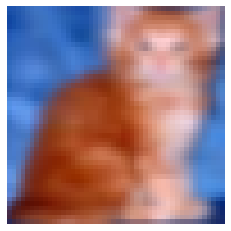

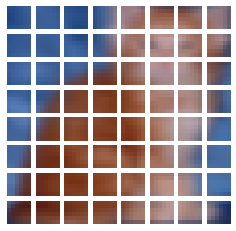

In [8]:
# Get a batch of images.
image_batch = next(iter(train_ds))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmeneted_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches()

# Get the patches from the batched images.
patches = patch_layer(images=augmeneted_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmeneted_images, patches=patches)

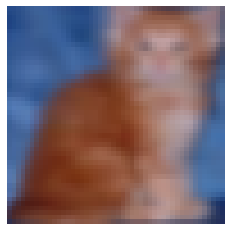

In [9]:
# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

# Patch Encoder

This layer deals with encoding the pathces and adding the positional embedding too. The layer holds two utility functions:
- `get_random_indices`: This function provides randomly sampled mask and unmask indices.
- `show_masked_image`: A utility function that plots a random masked image.

In [10]:
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # input to the encoder
                masked_embeddings,  # first part of input to the decoder
                unmasked_positions,  # added to the encoder outputs
                mask_indices,  # the indices that were masked
                unmask_indices,  # the indices that were unmaksed
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]

        return mask_indices, unmask_indices

    def show_masked_image(self, patches, unmask_indices):
        # choose a random patch and it corresponding unmask index
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # build a numpy array of same shape as pathc
        new_patch = np.zeros_like(patch)

        # iterate of the new_patch and plug the unmasked patches
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

In [11]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)

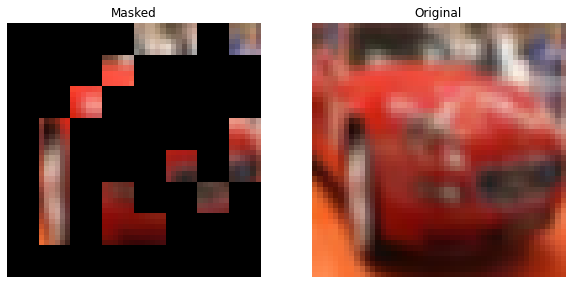

In [12]:
# Show a maksed patch image.
new_patch, random_index = patch_encoder.show_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmeneted_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

# MLP

In [13]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Encoder

In [14]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

# Decoder

In [15]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")

# MaskedAutoEncoder Model

This is the trainer model where we encapsulate the training logic.

In [16]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmeneted_images = self.test_augmentation_model(images)
        else:
            augmeneted_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmeneted_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

# Model init

In [17]:
keras.backend.clear_session()

train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

## Training callbacks

In [18]:
# Taking a batch of test inputs to measure model's progress.
test_images = next(iter(test_ds))


class TrainMonitor(tf.keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmeneted_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmeneted_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.show_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmeneted_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

In [19]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

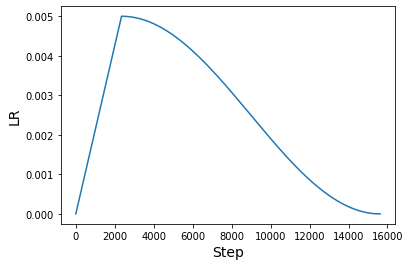

In [20]:
total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_steps = int(total_steps * 0.15)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

In [21]:
timestamp = datetime.utcnow().strftime("%y%m%d-%H%M%S")

train_callbacks = [
    keras.callbacks.TensorBoard(log_dir=f"mae_logs_{timestamp}"),
    TrainMonitor(epoch_interval=5),
]

# Compilation and training

In [22]:
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)

Epoch 1/100
156/157 [============================>.] - ETA: 0s - loss: 0.0511 - mae: 0.1820
Idx chosen: 92


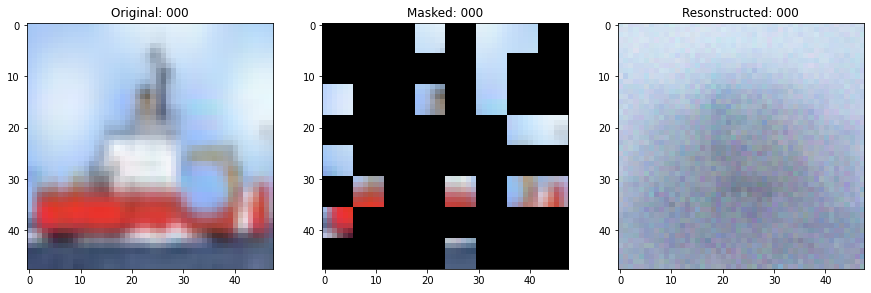

157/157 [==============================] - 16s 62ms/step - loss: 0.0511 - mae: 0.1819 - val_loss: 0.0428 - val_mae: 0.1658
Epoch 2/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0383 - mae: 0.1544 - val_loss: 0.0339 - val_mae: 0.1427
Epoch 3/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0326 - mae: 0.1395 - val_loss: 0.0302 - val_mae: 0.1336
Epoch 4/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0293 - mae: 0.1306 - val_loss: 0.0283 - val_mae: 0.1270
Epoch 5/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0266 - mae: 0.1235 - val_loss: 0.0259 - val_mae: 0.1208
Epoch 6/100
156/157 [============================>.] - ETA: 0s - loss: 0.0246 - mae: 0.1181
Idx chosen: 14


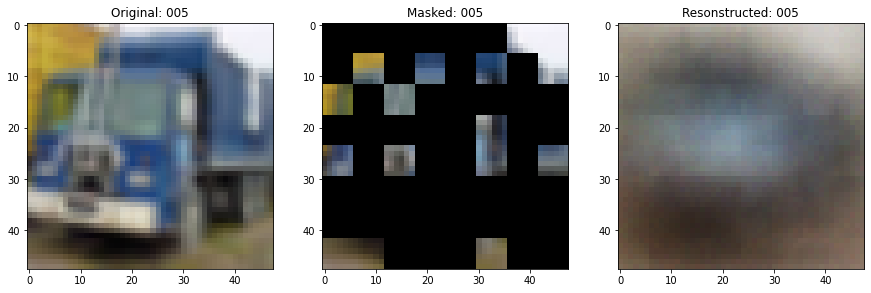

157/157 [==============================] - 9s 58ms/step - loss: 0.0246 - mae: 0.1181 - val_loss: 0.0243 - val_mae: 0.1172
Epoch 7/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0232 - mae: 0.1140 - val_loss: 0.0233 - val_mae: 0.1126
Epoch 8/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0223 - mae: 0.1115 - val_loss: 0.0219 - val_mae: 0.1098
Epoch 9/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0215 - mae: 0.1090 - val_loss: 0.0226 - val_mae: 0.1140
Epoch 10/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0210 - mae: 0.1073 - val_loss: 0.0215 - val_mae: 0.1093
Epoch 11/100
156/157 [============================>.] - ETA: 0s - loss: 0.0206 - mae: 0.1062
Idx chosen: 106


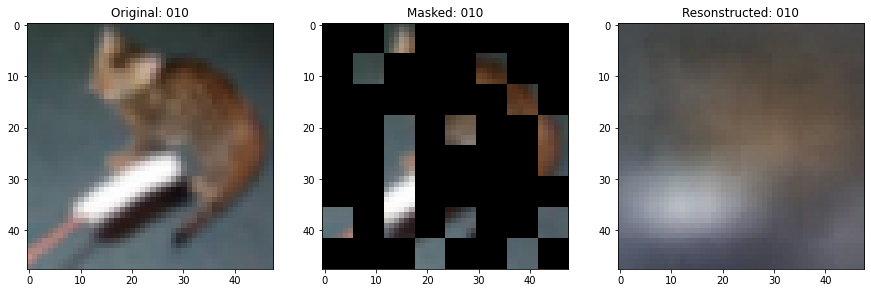

157/157 [==============================] - 9s 58ms/step - loss: 0.0206 - mae: 0.1062 - val_loss: 0.0204 - val_mae: 0.1049
Epoch 12/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0202 - mae: 0.1050 - val_loss: 0.0211 - val_mae: 0.1066
Epoch 13/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0200 - mae: 0.1042 - val_loss: 0.0208 - val_mae: 0.1071
Epoch 14/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0197 - mae: 0.1032 - val_loss: 0.0197 - val_mae: 0.1036
Epoch 15/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0195 - mae: 0.1026 - val_loss: 0.0195 - val_mae: 0.1020
Epoch 16/100
156/157 [============================>.] - ETA: 0s - loss: 0.0192 - mae: 0.1017
Idx chosen: 71


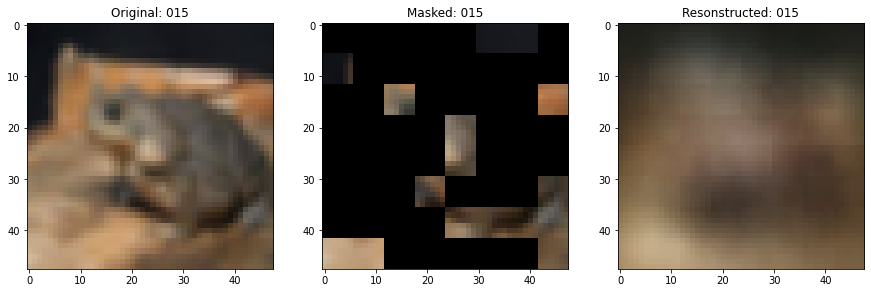

157/157 [==============================] - 9s 58ms/step - loss: 0.0192 - mae: 0.1017 - val_loss: 0.0193 - val_mae: 0.1026
Epoch 17/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0189 - mae: 0.1005 - val_loss: 0.0194 - val_mae: 0.1015
Epoch 18/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0190 - mae: 0.1008 - val_loss: 0.0194 - val_mae: 0.1033
Epoch 19/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0186 - mae: 0.0996 - val_loss: 0.0186 - val_mae: 0.0984
Epoch 20/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0185 - mae: 0.0991 - val_loss: 0.0184 - val_mae: 0.0992
Epoch 21/100
156/157 [============================>.] - ETA: 0s - loss: 0.0184 - mae: 0.0990
Idx chosen: 188


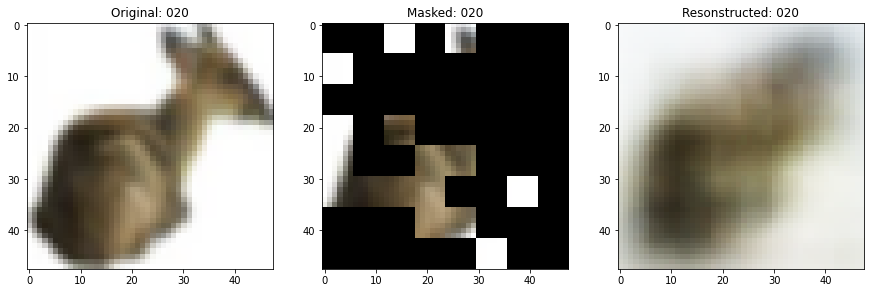

157/157 [==============================] - 9s 58ms/step - loss: 0.0184 - mae: 0.0990 - val_loss: 0.0185 - val_mae: 0.0999
Epoch 22/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0183 - mae: 0.0986 - val_loss: 0.0182 - val_mae: 0.0974
Epoch 23/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0182 - mae: 0.0983 - val_loss: 0.0182 - val_mae: 0.0978
Epoch 24/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0182 - mae: 0.0981 - val_loss: 0.0180 - val_mae: 0.0965
Epoch 25/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0180 - mae: 0.0976 - val_loss: 0.0187 - val_mae: 0.0996
Epoch 26/100
156/157 [============================>.] - ETA: 0s - loss: 0.0180 - mae: 0.0975
Idx chosen: 20


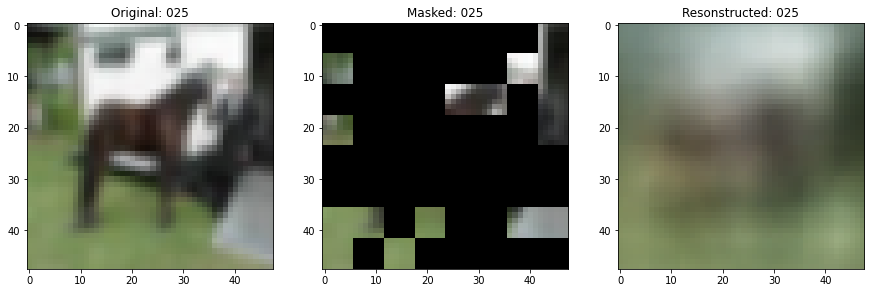

157/157 [==============================] - 9s 58ms/step - loss: 0.0180 - mae: 0.0975 - val_loss: 0.0185 - val_mae: 0.0991
Epoch 27/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0179 - mae: 0.0973 - val_loss: 0.0181 - val_mae: 0.0965
Epoch 28/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0179 - mae: 0.0970 - val_loss: 0.0178 - val_mae: 0.0967
Epoch 29/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0177 - mae: 0.0966 - val_loss: 0.0181 - val_mae: 0.0980
Epoch 30/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0177 - mae: 0.0963 - val_loss: 0.0178 - val_mae: 0.0960
Epoch 31/100
156/157 [============================>.] - ETA: 0s - loss: 0.0176 - mae: 0.0962
Idx chosen: 102


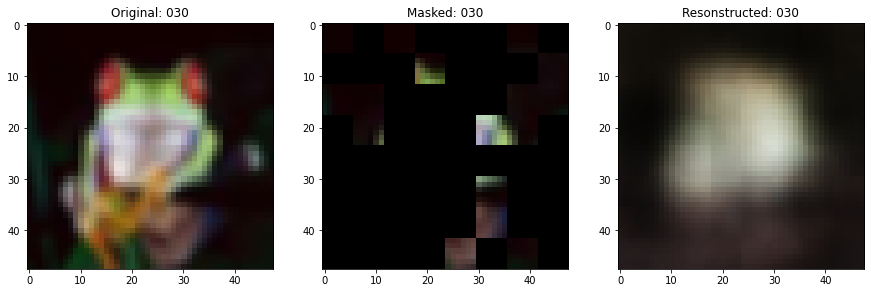

157/157 [==============================] - 9s 58ms/step - loss: 0.0176 - mae: 0.0962 - val_loss: 0.0177 - val_mae: 0.0960
Epoch 32/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0176 - mae: 0.0961 - val_loss: 0.0177 - val_mae: 0.0965
Epoch 33/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0176 - mae: 0.0960 - val_loss: 0.0174 - val_mae: 0.0954
Epoch 34/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0174 - mae: 0.0955 - val_loss: 0.0178 - val_mae: 0.0958
Epoch 35/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0174 - mae: 0.0954 - val_loss: 0.0175 - val_mae: 0.0963
Epoch 36/100
156/157 [============================>.] - ETA: 0s - loss: 0.0173 - mae: 0.0951
Idx chosen: 121


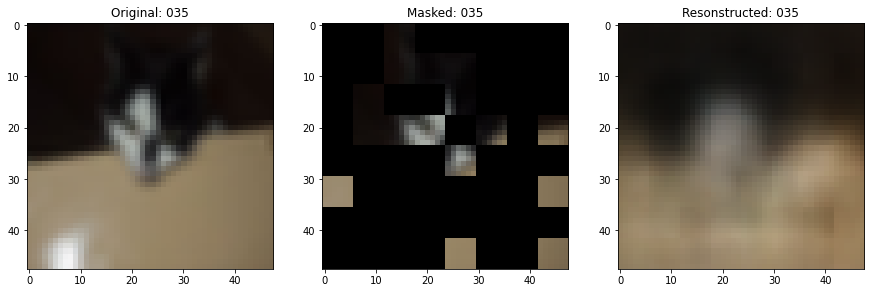

157/157 [==============================] - 9s 58ms/step - loss: 0.0173 - mae: 0.0951 - val_loss: 0.0177 - val_mae: 0.0956
Epoch 37/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0173 - mae: 0.0952 - val_loss: 0.0174 - val_mae: 0.0948
Epoch 38/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0172 - mae: 0.0946 - val_loss: 0.0175 - val_mae: 0.0955
Epoch 39/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0172 - mae: 0.0947 - val_loss: 0.0173 - val_mae: 0.0952
Epoch 40/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0171 - mae: 0.0944 - val_loss: 0.0172 - val_mae: 0.0947
Epoch 41/100
157/157 [==============================] - ETA: 0s - loss: 0.0170 - mae: 0.0941
Idx chosen: 210


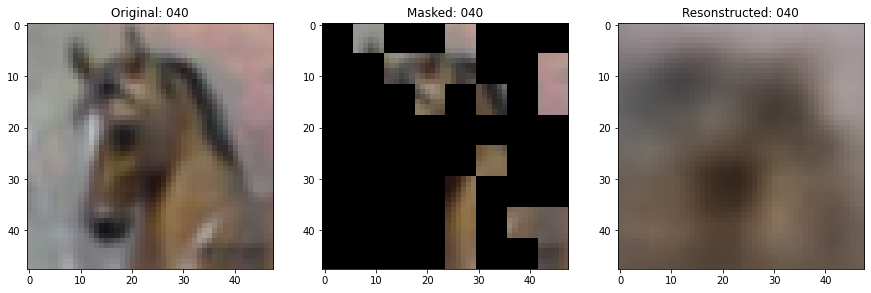

157/157 [==============================] - 9s 58ms/step - loss: 0.0170 - mae: 0.0941 - val_loss: 0.0172 - val_mae: 0.0942
Epoch 42/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0170 - mae: 0.0940 - val_loss: 0.0172 - val_mae: 0.0948
Epoch 43/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0169 - mae: 0.0938 - val_loss: 0.0175 - val_mae: 0.0951
Epoch 44/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0168 - mae: 0.0935 - val_loss: 0.0169 - val_mae: 0.0933
Epoch 45/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0168 - mae: 0.0933 - val_loss: 0.0168 - val_mae: 0.0930
Epoch 46/100
156/157 [============================>.] - ETA: 0s - loss: 0.0169 - mae: 0.0935
Idx chosen: 214


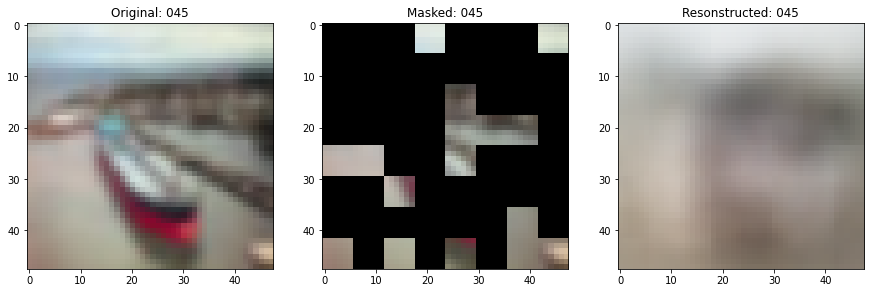

157/157 [==============================] - 9s 58ms/step - loss: 0.0169 - mae: 0.0935 - val_loss: 0.0173 - val_mae: 0.0940
Epoch 47/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0167 - mae: 0.0930 - val_loss: 0.0168 - val_mae: 0.0928
Epoch 48/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0166 - mae: 0.0927 - val_loss: 0.0169 - val_mae: 0.0933
Epoch 49/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0167 - mae: 0.0928 - val_loss: 0.0169 - val_mae: 0.0935
Epoch 50/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0166 - mae: 0.0926 - val_loss: 0.0168 - val_mae: 0.0933
Epoch 51/100
156/157 [============================>.] - ETA: 0s - loss: 0.0166 - mae: 0.0926
Idx chosen: 74


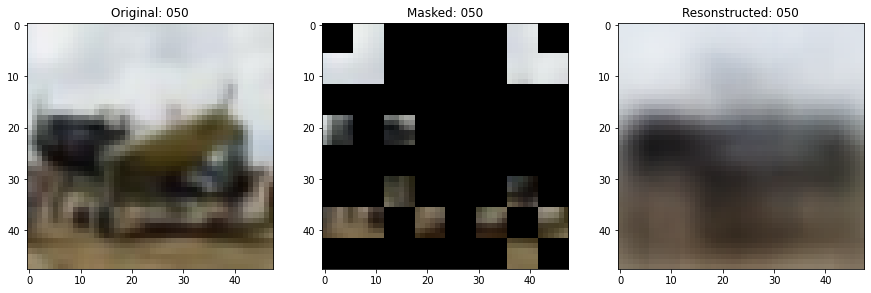

157/157 [==============================] - 9s 59ms/step - loss: 0.0166 - mae: 0.0926 - val_loss: 0.0167 - val_mae: 0.0925
Epoch 52/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0165 - mae: 0.0922 - val_loss: 0.0172 - val_mae: 0.0948
Epoch 53/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0165 - mae: 0.0923 - val_loss: 0.0166 - val_mae: 0.0921
Epoch 54/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0164 - mae: 0.0920 - val_loss: 0.0167 - val_mae: 0.0919
Epoch 55/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0164 - mae: 0.0919 - val_loss: 0.0165 - val_mae: 0.0914
Epoch 56/100
156/157 [============================>.] - ETA: 0s - loss: 0.0163 - mae: 0.0915
Idx chosen: 202


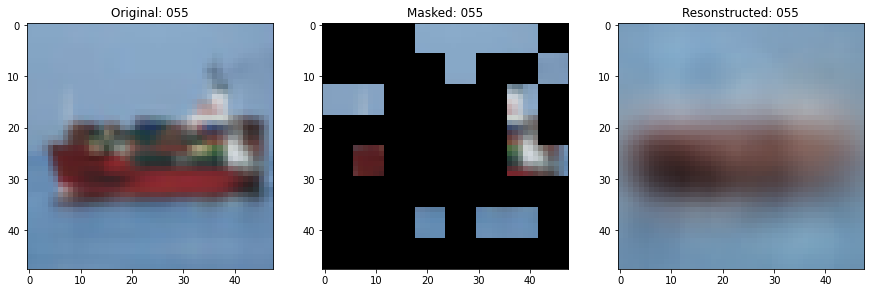

157/157 [==============================] - 9s 58ms/step - loss: 0.0163 - mae: 0.0915 - val_loss: 0.0165 - val_mae: 0.0926
Epoch 57/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0163 - mae: 0.0915 - val_loss: 0.0163 - val_mae: 0.0912
Epoch 58/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0163 - mae: 0.0914 - val_loss: 0.0165 - val_mae: 0.0921
Epoch 59/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0162 - mae: 0.0911 - val_loss: 0.0164 - val_mae: 0.0921
Epoch 60/100
157/157 [==============================] - 9s 55ms/step - loss: 0.0162 - mae: 0.0910 - val_loss: 0.0163 - val_mae: 0.0914
Epoch 61/100
156/157 [============================>.] - ETA: 0s - loss: 0.0161 - mae: 0.0906
Idx chosen: 87


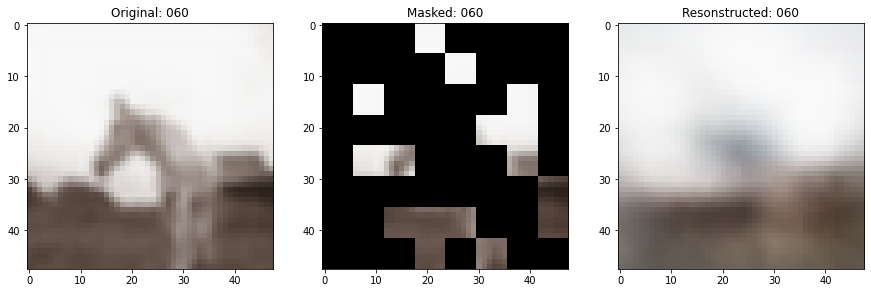

157/157 [==============================] - 9s 58ms/step - loss: 0.0161 - mae: 0.0906 - val_loss: 0.0162 - val_mae: 0.0903
Epoch 62/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0161 - mae: 0.0907 - val_loss: 0.0163 - val_mae: 0.0909
Epoch 63/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0160 - mae: 0.0903 - val_loss: 0.0161 - val_mae: 0.0903
Epoch 64/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0159 - mae: 0.0901 - val_loss: 0.0161 - val_mae: 0.0898
Epoch 65/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0159 - mae: 0.0898 - val_loss: 0.0161 - val_mae: 0.0905
Epoch 66/100
156/157 [============================>.] - ETA: 0s - loss: 0.0158 - mae: 0.0896
Idx chosen: 116


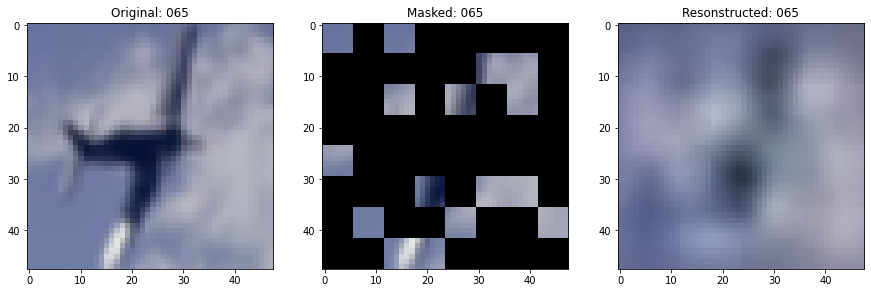

157/157 [==============================] - 9s 58ms/step - loss: 0.0158 - mae: 0.0896 - val_loss: 0.0164 - val_mae: 0.0914
Epoch 67/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0158 - mae: 0.0895 - val_loss: 0.0158 - val_mae: 0.0894
Epoch 68/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0157 - mae: 0.0891 - val_loss: 0.0158 - val_mae: 0.0895
Epoch 69/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0156 - mae: 0.0889 - val_loss: 0.0158 - val_mae: 0.0887
Epoch 70/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0156 - mae: 0.0889 - val_loss: 0.0159 - val_mae: 0.0894
Epoch 71/100
156/157 [============================>.] - ETA: 0s - loss: 0.0155 - mae: 0.0885
Idx chosen: 99


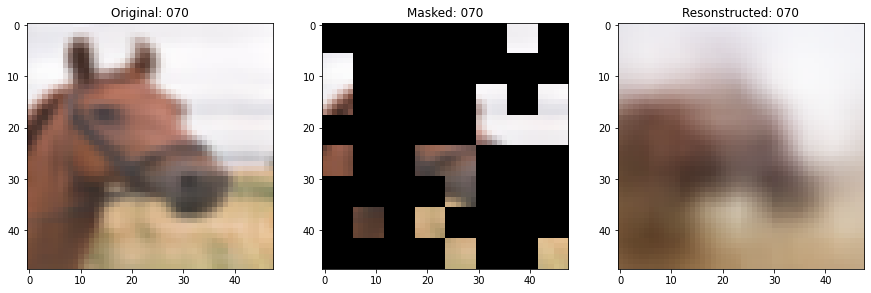

157/157 [==============================] - 9s 58ms/step - loss: 0.0155 - mae: 0.0885 - val_loss: 0.0158 - val_mae: 0.0891
Epoch 72/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0155 - mae: 0.0883 - val_loss: 0.0157 - val_mae: 0.0888
Epoch 73/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0155 - mae: 0.0882 - val_loss: 0.0156 - val_mae: 0.0879
Epoch 74/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0154 - mae: 0.0880 - val_loss: 0.0155 - val_mae: 0.0881
Epoch 75/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0153 - mae: 0.0877 - val_loss: 0.0155 - val_mae: 0.0879
Epoch 76/100
156/157 [============================>.] - ETA: 0s - loss: 0.0153 - mae: 0.0876
Idx chosen: 103


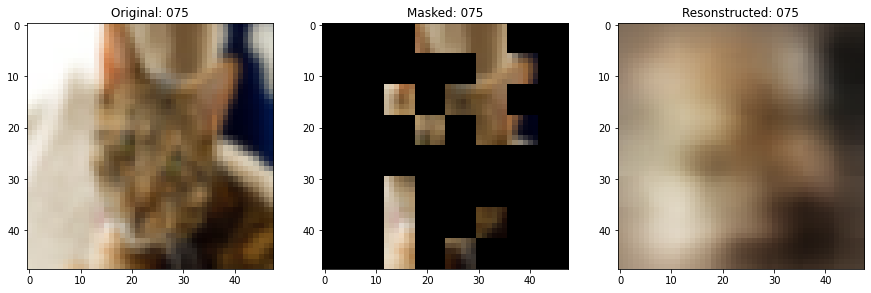

157/157 [==============================] - 9s 58ms/step - loss: 0.0153 - mae: 0.0876 - val_loss: 0.0154 - val_mae: 0.0877
Epoch 77/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0153 - mae: 0.0874 - val_loss: 0.0154 - val_mae: 0.0876
Epoch 78/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0152 - mae: 0.0872 - val_loss: 0.0153 - val_mae: 0.0871
Epoch 79/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0152 - mae: 0.0872 - val_loss: 0.0152 - val_mae: 0.0869
Epoch 80/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0152 - mae: 0.0870 - val_loss: 0.0152 - val_mae: 0.0864
Epoch 81/100
156/157 [============================>.] - ETA: 0s - loss: 0.0152 - mae: 0.0869
Idx chosen: 151


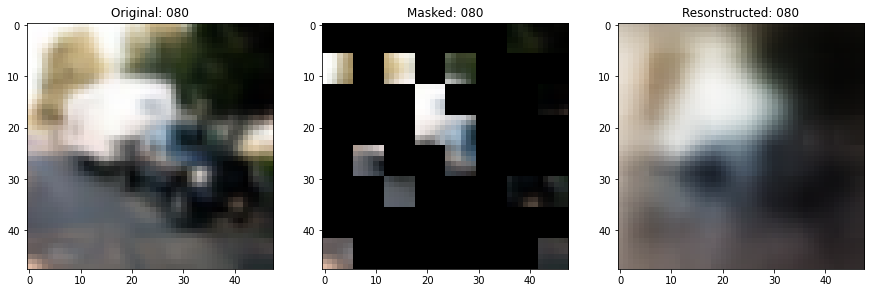

157/157 [==============================] - 9s 58ms/step - loss: 0.0152 - mae: 0.0869 - val_loss: 0.0152 - val_mae: 0.0866
Epoch 82/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0151 - mae: 0.0866 - val_loss: 0.0152 - val_mae: 0.0865
Epoch 83/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0151 - mae: 0.0865 - val_loss: 0.0151 - val_mae: 0.0863
Epoch 84/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0151 - mae: 0.0865 - val_loss: 0.0153 - val_mae: 0.0871
Epoch 85/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0150 - mae: 0.0863 - val_loss: 0.0151 - val_mae: 0.0861
Epoch 86/100
157/157 [==============================] - ETA: 0s - loss: 0.0150 - mae: 0.0861
Idx chosen: 130


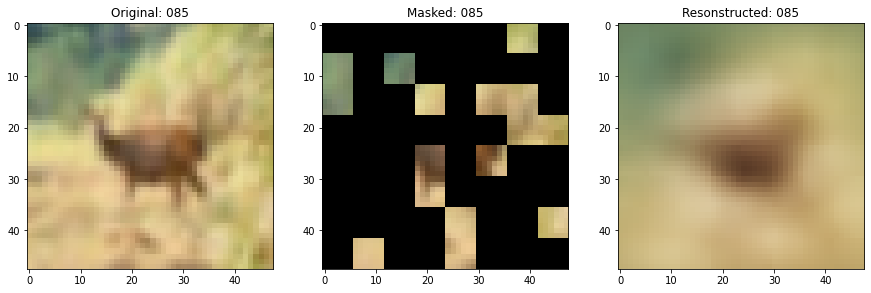

157/157 [==============================] - 9s 58ms/step - loss: 0.0150 - mae: 0.0861 - val_loss: 0.0151 - val_mae: 0.0860
Epoch 87/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0149 - mae: 0.0860 - val_loss: 0.0150 - val_mae: 0.0857
Epoch 88/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0150 - mae: 0.0861 - val_loss: 0.0150 - val_mae: 0.0859
Epoch 89/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0149 - mae: 0.0858 - val_loss: 0.0150 - val_mae: 0.0857
Epoch 90/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0149 - mae: 0.0859 - val_loss: 0.0149 - val_mae: 0.0855
Epoch 91/100
156/157 [============================>.] - ETA: 0s - loss: 0.0148 - mae: 0.0857
Idx chosen: 149


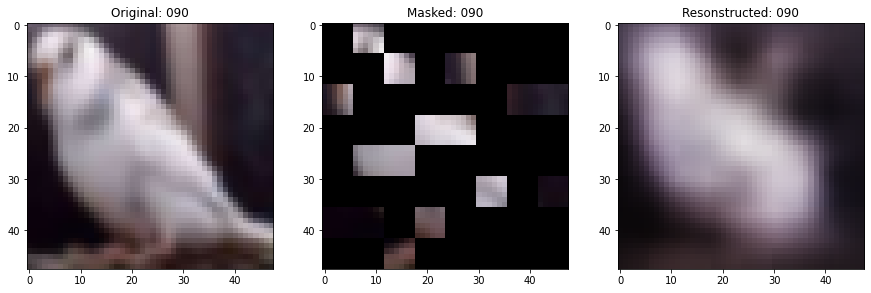

157/157 [==============================] - 9s 58ms/step - loss: 0.0148 - mae: 0.0857 - val_loss: 0.0150 - val_mae: 0.0857
Epoch 92/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0148 - mae: 0.0857 - val_loss: 0.0149 - val_mae: 0.0856
Epoch 93/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0149 - mae: 0.0858 - val_loss: 0.0149 - val_mae: 0.0856
Epoch 94/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0149 - mae: 0.0858 - val_loss: 0.0150 - val_mae: 0.0856
Epoch 95/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0148 - mae: 0.0857 - val_loss: 0.0150 - val_mae: 0.0858
Epoch 96/100
156/157 [============================>.] - ETA: 0s - loss: 0.0149 - mae: 0.0859
Idx chosen: 52


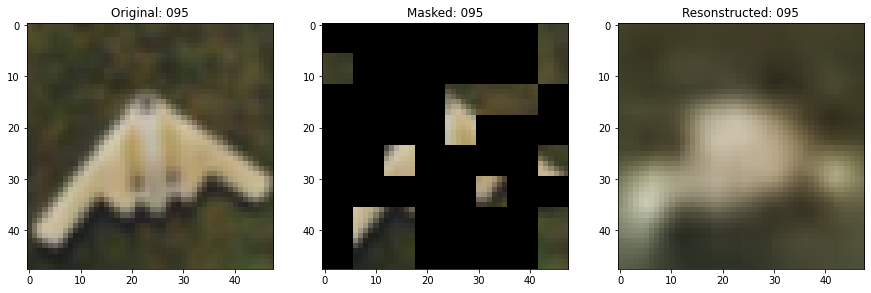

157/157 [==============================] - 9s 58ms/step - loss: 0.0149 - mae: 0.0859 - val_loss: 0.0150 - val_mae: 0.0858
Epoch 97/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0150 - mae: 0.0862 - val_loss: 0.0151 - val_mae: 0.0861
Epoch 98/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0150 - mae: 0.0863 - val_loss: 0.0151 - val_mae: 0.0864
Epoch 99/100
157/157 [==============================] - 9s 56ms/step - loss: 0.0151 - mae: 0.0870 - val_loss: 0.0153 - val_mae: 0.0872
Epoch 100/100
157/157 [==============================] - 9s 57ms/step - loss: 0.0153 - mae: 0.0881 - val_loss: 0.0155 - val_mae: 0.0890


In [23]:
history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks,
)

In [24]:
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

40/40 [==============================] - 1s 19ms/step - loss: 0.0156 - mae: 0.0891
Loss: 0.02
MAE: 0.09


# Downstrean Task

In [25]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing)
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches (Patches)           (None, 64, 108)           0         
                                                                 
 patch_encoder (PatchEncoder  (None, 64, 128)          22252     
 )                                                               
                                                                 
 mae_encoder (Functional)    (None, None, 128)         990976    
                                                                 
 batch_normalization (BatchN  (None, 64, 128)          512       
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                

In [26]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)


train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

In [27]:
linear_probe_epochs = 50
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")

Epoch 1/50
157/157 [==============================] - 12s 58ms/step - loss: 2.2339 - accuracy: 0.1761 - val_loss: 2.0413 - val_accuracy: 0.3000
Epoch 2/50
157/157 [==============================] - 9s 55ms/step - loss: 1.9320 - accuracy: 0.3419 - val_loss: 1.8130 - val_accuracy: 0.3756
Epoch 3/50
157/157 [==============================] - 9s 55ms/step - loss: 1.7824 - accuracy: 0.3842 - val_loss: 1.7124 - val_accuracy: 0.4039
Epoch 4/50
157/157 [==============================] - 9s 55ms/step - loss: 1.7088 - accuracy: 0.4047 - val_loss: 1.6584 - val_accuracy: 0.4182
Epoch 5/50
157/157 [==============================] - 9s 55ms/step - loss: 1.6683 - accuracy: 0.4121 - val_loss: 1.6255 - val_accuracy: 0.4278
Epoch 6/50
157/157 [==============================] - 9s 55ms/step - loss: 1.6361 - accuracy: 0.4230 - val_loss: 1.5998 - val_accuracy: 0.4336
Epoch 7/50
157/157 [==============================] - 9s 55ms/step - loss: 1.6191 - accuracy: 0.4236 - val_loss: 1.5833 - val_accuracy: 0.439

In [28]:
downstream_model.save(f"linear_probe_{timestamp}", include_optimizer=False)

INFO:tensorflow:Assets written to: linear_probe_211121-072602/assets


INFO:tensorflow:Assets written to: linear_probe_211121-072602/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
